# Water Management Single Scenario Analysis

This notebook provides a detailed analysis of a single scenario water allocation simulation. The analysis helps understand how different policies affect:
- Actor behavior and cooperation
- Water allocation and usage
- Economic and ecological impacts

## Setup and Configuration

In [357]:
import numpy as np
import matplotlib.pyplot as plt
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import seaborn as sns
from types import MethodType
from types import MethodType
import random
import itertools
from copy import deepcopy
import copy

## Policy Definition

Below we define two key policies that regulate water allocation:

1. **Quota Policy**: Determines how much water each actor is allowed to pump
2. **Incentive Policy**: Uses fines and subsidies to influence actor behavior

You can modify these policies to test different regulation strategies.

In [ ]:
from scipy.ndimage import gaussian_filter1d

class EvolutionnarySearch:
    def __init__(
        self,
        simulation,
        p_best_parents=2,
        pop_size=20,
        n_gen=30,
        mutation_rate=0.2,
        initial_mutation_spread=0.1,
        econ_weight=1,
        ecol_weight=1,
    ):
        """
        Create an EvolutionnarySearch object to run a parameter exploration around policies.

        Args:
            simulation: configurated simulation wich will serve as evaluation protocol.
            p_best: proportion of best individus to select as parent for next generation : total_ind // p_best.
            pop_size: number of generated variants per generation.
            n_gen: number of generation.
            mutation_rate: the proportion of children that will differ from parents.
            initial_mutation_spread: how much childrens will differ from parents (decreasing along generation).
            econ_weight: how economic impact is considerated in adjusted_score consideration.
            ecol_weight: how ecologic impact is considerated in adjusted_score consideration.

        Returns:
            EvolutionnarySearch object ready to run
        """
        self.simulation = simulation
        self.p_best_parents = p_best_parents
        self.pop_size = pop_size
        self.n_gen = n_gen
        self.mutation_rate = mutation_rate
        self.initial_mutation_spread = initial_mutation_spread
        self.econ_weight = econ_weight
        self.ecol_weight = ecol_weight
        self.execution_results = []

    def generate_individuals(self):
        """
        Generate required params for both policies.

        Returns:
            dict: Dictionary containing parameters for both incentive and quota policies \n
            {
                "incentive_params":{...},\n
                "quota_params": {...}
            }
        """
        return {
            "incentive_params": {
                # crisis params
                    "defect_income_factor": random.uniform(0.01, 1),
                    "defect_prio_factor": random.uniform(0.01, 2),
                    "coop_fine_inc": random.uniform(0.1, 2),
                    "coop_fine_prio": random.uniform(0.9, 3),
                    "coop_fine_stress": random.uniform(0.1, 5),
                    "coop_sub_inc_factor": random.uniform(0.1, 2),
                    "coop_sub_prio": random.uniform(0.1, 3),
                    "coop_sub_stress": random.uniform(0.9, 5),
            },
            "quota_params": {
                "avg_pump_factor": random.uniform(0.01, 2),
                "actor_priority_factor": random.uniform(0.01, 2),
                "crisis_level_factor": random.uniform(0.01, 3),
            },
        }

    def mutate(self, ind, gen):
        """
        Mutate parameters of an individual. Operates on both 'quota_params' and 'incentive_params'.

        Args:
            ind: individu to mutate.
            gen: generation number, wich will impact the strengh of mutation.

        Returns:
            dict: mutated individual
        """
        ind = deepcopy(ind)

        current_mutation_spread = self.initial_mutation_spread * ((self.n_gen - gen) / self.n_gen)
        print(f"current_mutation_spread : {current_mutation_spread}")
        
        for policy_key in ["quota_params", "incentive_params"]:
            for param_key in ind[policy_key]:
                if random.random() < self.mutation_rate:
                    ind[policy_key][param_key] *= np.random.normal(0, current_mutation_spread)

        return ind

    def select(self, population, scores):
        """
        Select half of the best individuals from the population based on their scores.

        Returns:
            tab of inidividus.
        """

        return [ind for _, ind in sorted(zip(scores, population), key=lambda x: -x[0])][
            : self.pop_size // self.p_best_parents
        ]

    def make_quota_function(self, params):
        """
        Based on given parameters it generate a quota policy.

        Returns:
            func: Quota policy.
        """

        def custom_quota(self, crisis_level, actors_priority, avg_pump, DOE, DCR):
            def min_max_normalize(array, force_min=None, force_max=None):
                if force_min is not None and force_max is not None:
                    min_val = force_min
                    max_val = force_max
                else:
                    min_val = np.min(array)
                    max_val = np.max(array)

                if max_val == min_val:
                    return np.zeros_like(array)
                return (array - min_val) / (max_val - min_val)
            EPISLON = 5e-2
            actors_priority_norm = min_max_normalize(actors_priority) + EPISLON
            crisis_level_norm = min_max_normalize(np.array([crisis_level]), force_min=-1, force_max=2) + EPISLON

            quota = (
                params["avg_pump_factor"] * avg_pump
                * params["actor_priority_factor"] * actors_priority_norm
                * params["crisis_level_factor"] * crisis_level_norm[0]
            )
            # Forcer des quotas réalistes (>= 0)
            return np.clip(quota, 0, avg_pump)

        return custom_quota

    def make_incentive_function(self, params):
        """
        Based on given parameters it generate an incentive policy.

        Returns:
            func: Incentive policy.
        """

        def custom_incentive(
            self,
            actions: np.ndarray,
            actors_priority: np.ndarray,
            avg_incomes: np.ndarray,
            water_pump: np.ndarray,
            avg_pump: np.ndarray,
            is_crisis: np.ndarray,
            water_flows: np.ndarray,
            quota: np.ndarray,
            DOE=15,
            DCR=10,
        ):
            # Normalisation afin de pouvoir justifier des diffénreces de poids entre les variables
            def min_max_normalize(array, force_min=None, force_max=None):
                if force_min is not None and force_max is not None:
                    min_val = force_min
                    max_val = force_max
                else:
                    min_val = np.min(array)
                    max_val = np.max(array)

                if max_val == min_val:
                    return np.zeros_like(array)
                return (array - min_val) / (max_val - min_val)

            # Initialisation du vecteur de prénalités / subventions
            fine = np.zeros(self.nb_actors)

            # On applique la normalisation plus une petite valeur pour éviter les multiplications par 0
            EPSILON = 5e-2
            actors_priority_norm = min_max_normalize(actors_priority) + EPSILON
            is_crisis_norm = min_max_normalize(is_crisis, force_min=-1, force_max=2) + EPSILON
            # Niveau de crise actuel normalisé
            current_stress_level_norm = is_crisis_norm[-1]

            # Cette valeur est la valeur indiquant que tout le monde pompe à son habitude et ne risque pas de passer sous le DCR
            # Il ne faut donc pas passer en dessous
            critical_overall_demand_treshold = np.sum(avg_pump) + DCR

            # Une fois tous les indicateurs calculés on s'en sert pour déterminer les pénalités et subventions
            # Objectifs :
            # - Augmenter coop en temps de crise -> Diminuer l'impact écologique
            # - Baisser la coop en temps normal -> Augmenter l'impact économique car constaté
            # qu'une trop grande coopération est néfaste en temps normal, surtout en configuration de prédictions biasées
            for i in range(self.nb_actors):

                # Politique en temps normal
                if (current_stress_level_norm < 1 + EPSILON):
                    if (water_pump[i] > quota[i]):
                        # On encourage la NON coopération en temps normal via des subventions uniquement
                        fine[i] = -(
                            ((avg_incomes[i] / 5) * params["defect_income_factor"]) * (
                                    # Subvention proportionelle au 5ème des revenu pour moins d'impact écolo
                                  params["defect_prio_factor"] * (actors_priority_norm[i])
                                  )  # Plus la priorité est grande moins la subvention est élvée
                        )
                # Politique en temps de crise
                else:
                    # On encourage la coopération en temps de crise
                    if (water_pump[i] > quota[i]):
                        fine[i] = ((avg_incomes[i] / 10) * params["coop_fine_inc"]) * (
                                    # Amende proportionelle au 10ème des revenu pour moins d'impact éco
                                  params["coop_fine_prio"] * (1 / actors_priority_norm[i])
                                  )  * (# Plus la priorité est grande moins la pénalité est élvée
                                  params["coop_fine_stress"] * current_stress_level_norm
                                  )     # Plus le stress est grand plus la pénalité est élvée
                    else :
                        fine[i] = -(
                            (avg_incomes[i] * params["coop_sub_inc_factor"]) * (
                                # Subvention proportionelle au revenu pour plus d'impact
                                params["coop_sub_prio"] * (actors_priority_norm[i])
                            ) * ( # Plus la priorité est grande plus la subvention est élvée 
                                params["coop_sub_stress"] * current_stress_level_norm
                            )     # Plus le stress est grand plus la subvention est élvée
                        )

            if fine.max() != 0 and fine.min() != 0 and False:
                print(f"------------------- BEGIN Turn -------------------")
                print(f"max fine : {fine.max()}")
                print(f"min fine : {fine.min()}")
                print(f"current_stress_level_norm : {current_stress_level_norm}")
                print(f"adjusted_water_flow_gauss_evol_slope : {adjusted_water_flow_gauss_evol_slope}")
                print(f"    params[cf_avg_incomes]: {params["cf_avg_incomes"]}")
                print(f"    params[cf_actors_priority]: {params["cf_actors_priority"]}")
                print(f"    params[cf_curr_stress]: {params["cf_curr_stress"]}")
                print(f"    params[cs_avg_incomes]: {params["cs_avg_incomes"]}")
                print(f"    params[cs_actors_priority]: {params["cs_actors_priority"]}")
                print(f"    params[cs_curr_stress]: {params["cs_curr_stress"]}")
                print(f"    params[pf_wf_slope]: {params["pf_wf_slope"]}")

                print(f"------------------- END Turn -------------------")
                import time
                time.sleep(0.5)
            return fine

        return custom_incentive

    def score_fn(self, incentive_policy, quota_policy, simulation):
        """
        Run a simulation based on give policy and compute scores.

        Returns:
            Tuple:  - adjusted_score = economic_impact - ecological_impact.\n
                    - ecological_impact = ecological impact of the simulation.\n
                    - economic_impact = economic impact of the simulation.
        """
        # Lier les politiques
        simulation.incentive_policy = MethodType(incentive_policy, simulation)
        simulation.compute_actor_quota = MethodType(quota_policy, simulation)

        simulation.run_simulation()
        ecological_impact, economic_impact = simulation.get_final_scores_scaled()

        adjusted_score = economic_impact - ecological_impact

        return adjusted_score, ecological_impact, economic_impact

    def get_best_result(self):
        adjusted_score = np.array(
            [r["adjusted_score"] for r in self.execution_results]
        )

        # Meilleur score
        best_idx = np.argmax(adjusted_score)
        return self.execution_results[best_idx]

    def run_search(self):
        """
        Run all simulations based on given search parameters.

        Returns:
            tab:
                - **dict**
                    - generation = generation number.
                    - quota_params = **dict** -> quota params.
                    - incentive_params = **dict** -> incentive params.
                    - ecological_impact = economic impact of the simulation.
                    - economic_impact = economic impact of the simulation.
                    - adjusted_score = economic impact of the simulation.
        """
        population = [self.generate_individuals() for _ in range(self.pop_size)]

        for gen in range(self.n_gen + 1):
            scored = [-999]
            # Pour tous les individus d'une génération, on évalue le score
            it = 0
            for ind in population:
                it = it + 1
                print(f"iteration gen {gen} : {it}")
                quota_policy = self.make_quota_function(ind["quota_params"])
                incentive_policy = self.make_incentive_function(ind["incentive_params"])
                adjusted_score, ecological_impact, economic_impact = self.score_fn(
                    incentive_policy, quota_policy, self.simulation
                )
                self.execution_results.append(
                    {
                        "generation": gen,
                        "quota_params": ind["quota_params"],
                        "incentive_params": ind["incentive_params"],
                        "ecological_impact": ecological_impact,
                        "economic_impact": economic_impact,
                        "adjusted_score": adjusted_score,
                        "simulation": self.simulation if adjusted_score >= max(scored) else None,
                    }
                )
                scored.append(adjusted_score)

            best_score = max(scored)
            print(f"Génération {gen}, meilleur score : {best_score:.4f}")

            # Reproduction, on prend la moitié des meilleurs et on les mutent
            if self.n_gen > 1:
                selected = self.select(population, scored)
                children = []
                while len(children) < self.pop_size:
                    parent = random.choice(selected)
                    child = self.mutate(parent, gen)
                    children.append(child)

            population = children

        # On retourne le réssultat d'éxecution au complet
        return self.execution_results


## Simulation Configuration and Execution

Now we'll configure and run the simulation with our defined policies:

In [359]:
# Configure simulation parameters
yaml_path = 'parameters/scenarios/1.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 400        # Number of weeks to simulate
params["nb_iterations"] = 10       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts

# Initialize and run simulation
simulation = wms.WaterManagementSimulation(**params)

search = EvolutionnarySearch(
    simulation=simulation,
    p_best_parents=2,
    pop_size=20,
    n_gen=3,
    mutation_rate=0.6,
    initial_mutation_spread=0.35,
)

execution_results = search.run_search()

iteration gen 0 : 1
iteration gen 0 : 2
iteration gen 0 : 3
iteration gen 0 : 4
iteration gen 0 : 5
iteration gen 0 : 6
iteration gen 0 : 7
iteration gen 0 : 8
iteration gen 0 : 9
iteration gen 0 : 10
iteration gen 0 : 11
iteration gen 0 : 12
iteration gen 0 : 13
iteration gen 0 : 14
iteration gen 0 : 15
iteration gen 0 : 16
iteration gen 0 : 17
iteration gen 0 : 18
iteration gen 0 : 19
iteration gen 0 : 20
Génération 0, meilleur score : 0.0218
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread : 0.35
current_mutation_spread 

In [360]:
import plotly.express as px
import pandas as pd

incentive_data = [d['incentive_params'] for d in search.execution_results]
quota_data = [d['quota_params'] for d in search.execution_results]
ecological_impact_data = {}
ecological_impact_data["ecological_impact"] = [d['ecological_impact'] for d in search.execution_results]
economic_impact_data = {}
economic_impact_data["economic_impact"] = [d['economic_impact'] for d in search.execution_results]

df = pd.concat([pd.DataFrame(incentive_data),
                pd.DataFrame(quota_data),
                pd.DataFrame(ecological_impact_data),
                pd.DataFrame(economic_impact_data)],
                axis=1)

df = df[df["ecological_impact"] > -2]
df = df[df["economic_impact"] > 0]

fig = px.parallel_coordinates(df, color="ecological_impact",
                              dimensions=df.columns,
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=0)
fig.show()

In [361]:
import plotly.express as px
import pandas as pd

gen_data = {}
gen_data["generation"] = [d['generation'] for d in search.execution_results]

df = pd.concat([pd.DataFrame(incentive_data),
                pd.DataFrame(quota_data),
                pd.DataFrame(ecological_impact_data),
                pd.DataFrame(economic_impact_data),
                pd.DataFrame(gen_data)],
                axis=1)

fig = px.parallel_coordinates(df, color="generation",
                              dimensions=df.columns,
                              color_continuous_scale=px.colors.diverging.Temps,
                              color_continuous_midpoint=1.5)
fig.show()

In [362]:
# Utilisation :
best_result = search.get_best_result()
print("✅ Meilleure combinaison trouvée :")
print("Adjusted score :",best_result["adjusted_score"])
print("ecological impact :",best_result["ecological_impact"])
print("economic impact :",best_result["economic_impact"])

✅ Meilleure combinaison trouvée :
Adjusted score : 0.021811123428683632
ecological impact : 0.8676767676767677
economic impact : 0.8894878911054513


In [363]:
pd.DataFrame(best_result["quota_params"], index=[0]).head()

,avg_pump_factor,actor_priority_factor,crisis_level_factor
0,0.601596,0.764486,1.254211


In [364]:
pd.DataFrame(best_result["incentive_params"], index=[0])

,defect_income_factor,defect_prio_factor,coop_fine_inc,coop_fine_prio,coop_fine_stress,coop_sub_inc_factor,coop_sub_prio,coop_sub_stress
0,0.591011,1.955031,1.10937,2.55652,2.86553,0.736863,2.078319,1.32948


In [365]:
# Configure simulation parameters
yaml_path = 'parameters/scenarios/1.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 700        # Number of weeks to simulate
params["nb_iterations"] = 20       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts

# Initialize and run simulation
simulation = wms.WaterManagementSimulation(**params)

# Apply our custom policies
simulation.incentive_policy = MethodType(search.make_incentive_function(best_result["incentive_params"]), simulation)
simulation.compute_actor_quota = MethodType(search.make_quota_function(best_result["quota_params"]), simulation)

# Run the simulation
simulation.run_simulation()

# Get final performance scores
ecological_impact, economic_impact = simulation.get_final_scores_scaled()

print(f"Simulation complete. Final scores:")
print(f"Ecological Impact: {ecological_impact:.4f} (lower is better)")
print(f"Economic Impact: {economic_impact:.4f} (higher is better)")

# Prepare for visualization
sns.set(style='whitegrid')
cmap = plt.get_cmap('Dark2')
actors_colors = [cmap(i) for i in range(simulation.nb_actors)]
riverflows_mean = np.mean(simulation.w_riverflows, axis=0)
x_values = range(params["total_turns"])

Simulation complete. Final scores:
Ecological Impact: 0.9565 (lower is better)
Economic Impact: 0.9201 (higher is better)


## 1. Water Resource Analysis

First, let's examine the water resource availability throughout the simulation period and how it relates to actor demands.

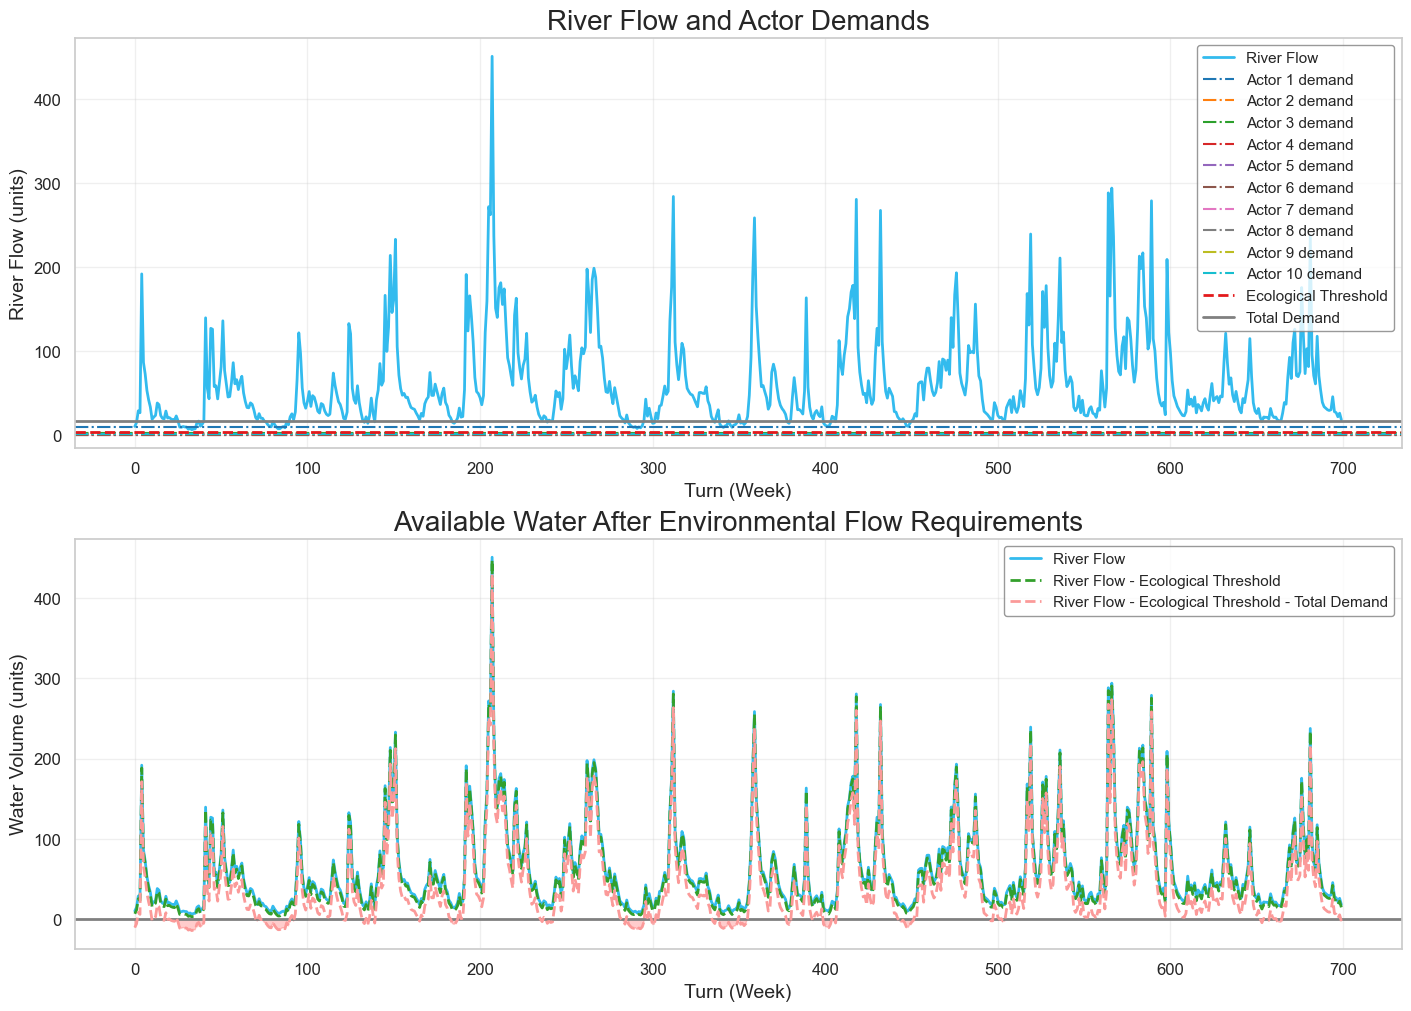

In [366]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot river flow
gtp.plot_river_flow(axes[0], x_values, riverflows_mean, simulation.actors_demands, simulation.DCR)
axes[0].set_title('River Flow and Actor Demands', fontsize=20)

# Plot remaining water after ecological threshold
gtp.plot_remaining_water(axes[1], x_values, riverflows_mean, simulation.actors_demands, simulation.DCR)
axes[1].set_title('Available Water After Environmental Flow Requirements', fontsize=20)

plt.show()

### Analysis of Water Resources

The top graph shows the raw river flow over time, along with each actor's water demand and the ecological threshold (DCR). The total demand line shows the sum of all actor demands.

The bottom graph shows the remaining water available for allocation after respecting the ecological threshold. When this line drops below zero (red shaded areas), it indicates periods where fulfilling all demands would breach the minimum environmental flow requirements.

## 2. Actor Behavior and Crisis Response

Now, let's analyze how actors behave in response to changing water availability and crisis levels.

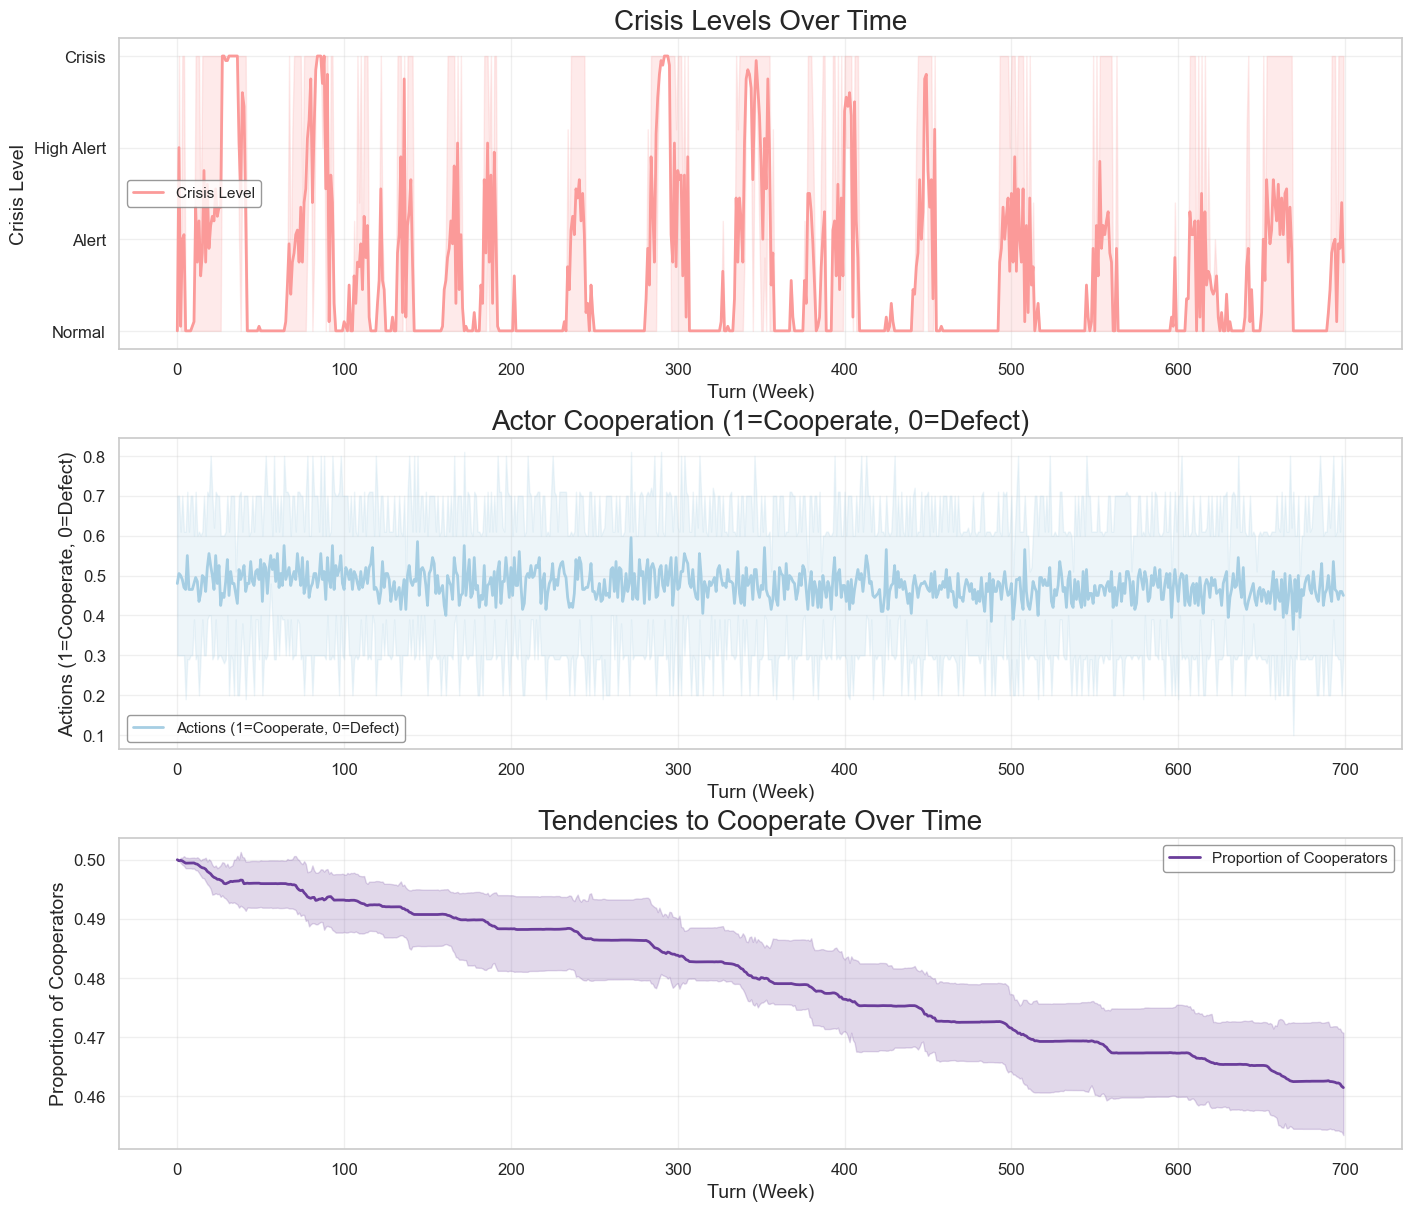

In [367]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot crisis levels
gtp.plot_data(axes[0], x_values, simulation, "w_crisis", mode="mean")
axes[0].set_title('Crisis Levels Over Time', fontsize=20)
axes[0].set_ylim(-1.2, 2.2)
axes[0].set_yticks([-1, 0, 1, 2])
axes[0].set_yticklabels(['Normal', 'Alert', 'High Alert', 'Crisis'])

# Plot actor cooperation actions
gtp.plot_data(axes[1], x_values, simulation, "h_actions", mode="mean")
axes[1].set_title('Actor Cooperation (1=Cooperate, 0=Defect)', fontsize=20)

# Plot tendencies to cooperate
gtp.plot_data(axes[2], x_values, simulation, "h_tendencies", mode="mean")
axes[2].set_title('Tendencies to Cooperate Over Time', fontsize=20)

plt.show()

### Analysis of Actor Behavior

These graphs reveal how actors respond to crisis situations:

- The **Crisis Level** graph shows when the system enters different states of water stress.
- The **Actor Cooperation** graph shows actors' decisions to either cooperate (1) or defect (0).
- The **Tendencies to Cooperate** graph shows the evolving probability of cooperation for each actor.

Notice how cooperation tendencies change in response to crisis events. This reveals how actors learn from experience and adapt their strategies based on outcomes.

## 3. Water Allocation and Economic Outcomes

Next, let's examine how water is allocated among actors and its economic impacts.

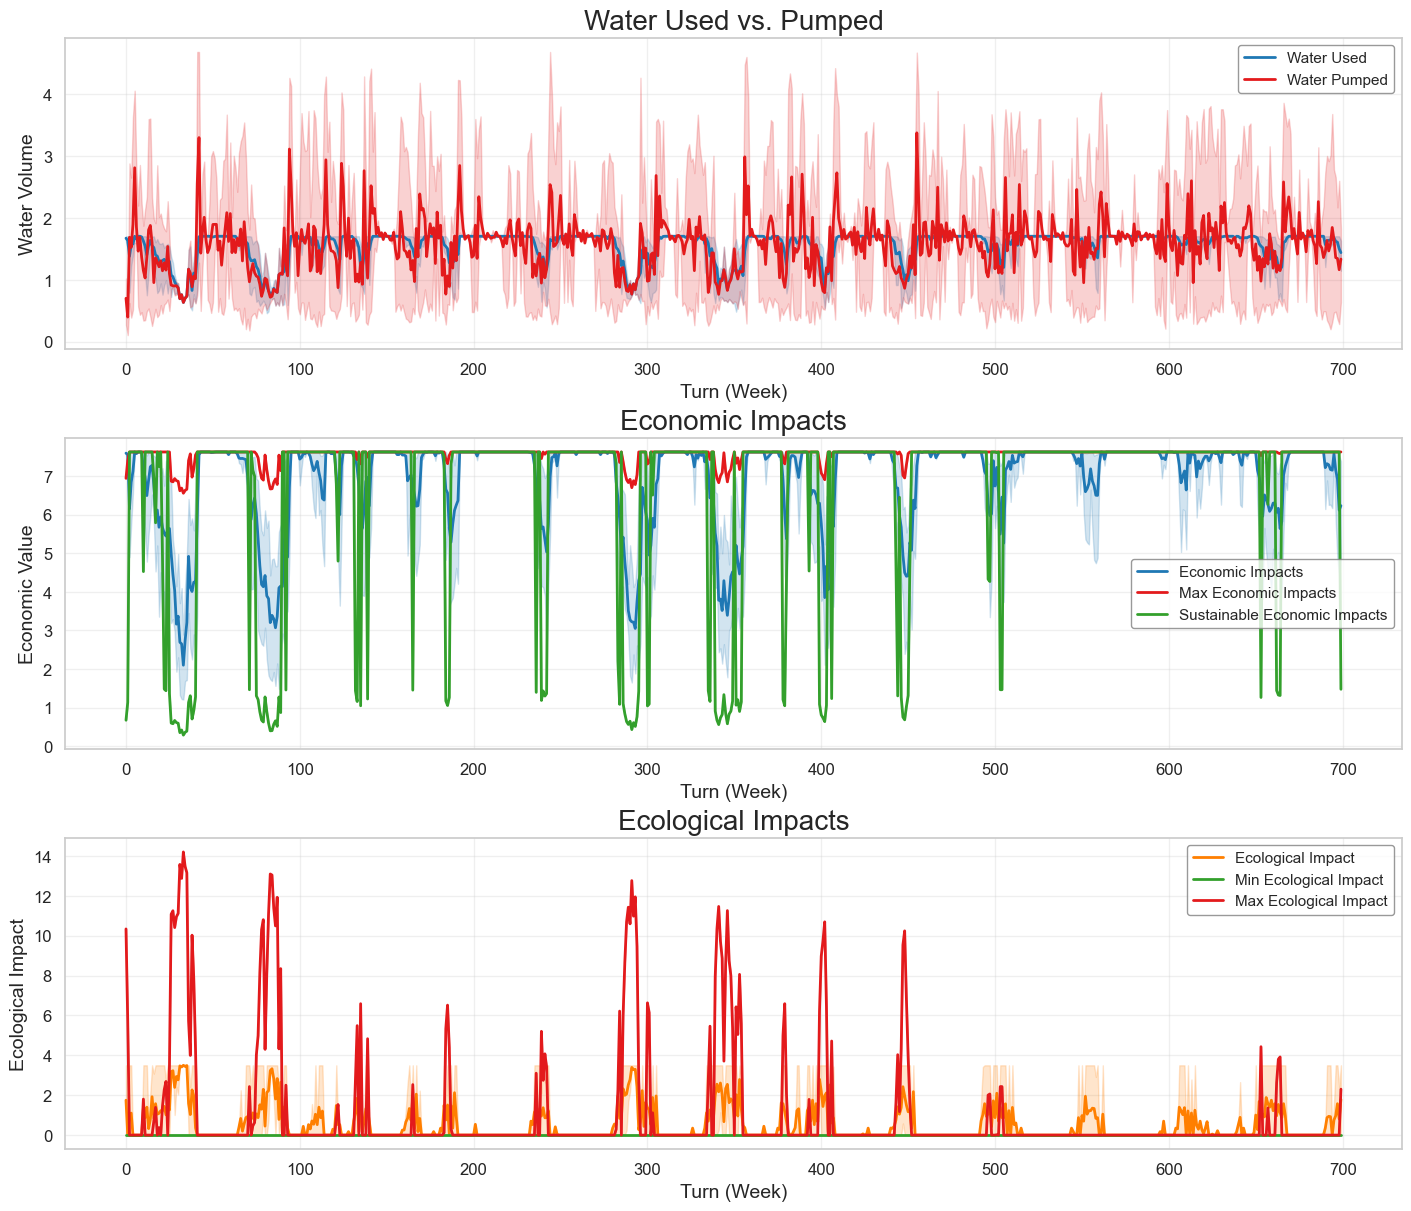

In [368]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot water usage
gtp.compare_data(
    axes[0], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Water Volume',
    title='Water Used vs. Pumped'
)

# Plot economic impacts
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Economic Value',
    title='Economic Impacts'
)

# Plot ecological impacts
gtp.compare_data(
    axes[2], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Ecological Impact',
    title='Ecological Impacts'
)

plt.show()

### Analysis of Allocation and Impacts

These graphs show the outcomes of the water allocation process:

- **Water Used vs. Pumped**: Compares water pumped from the river to water actually used. The difference goes into storage.
- **Economic Impacts**: Shows the actual economic value generated compared to theoretical maximum and sustainable minimum values.
- **Ecological Impacts**: Shows the environmental impact of water usage compared to minimum and maximum possible impacts.

These metrics help evaluate how well the policy balances economic benefits against ecological integrity.

## 4. Policy Effectiveness Analysis

Now let's analyze how the incentive policy (fines and subsidies) influenced actor behavior.

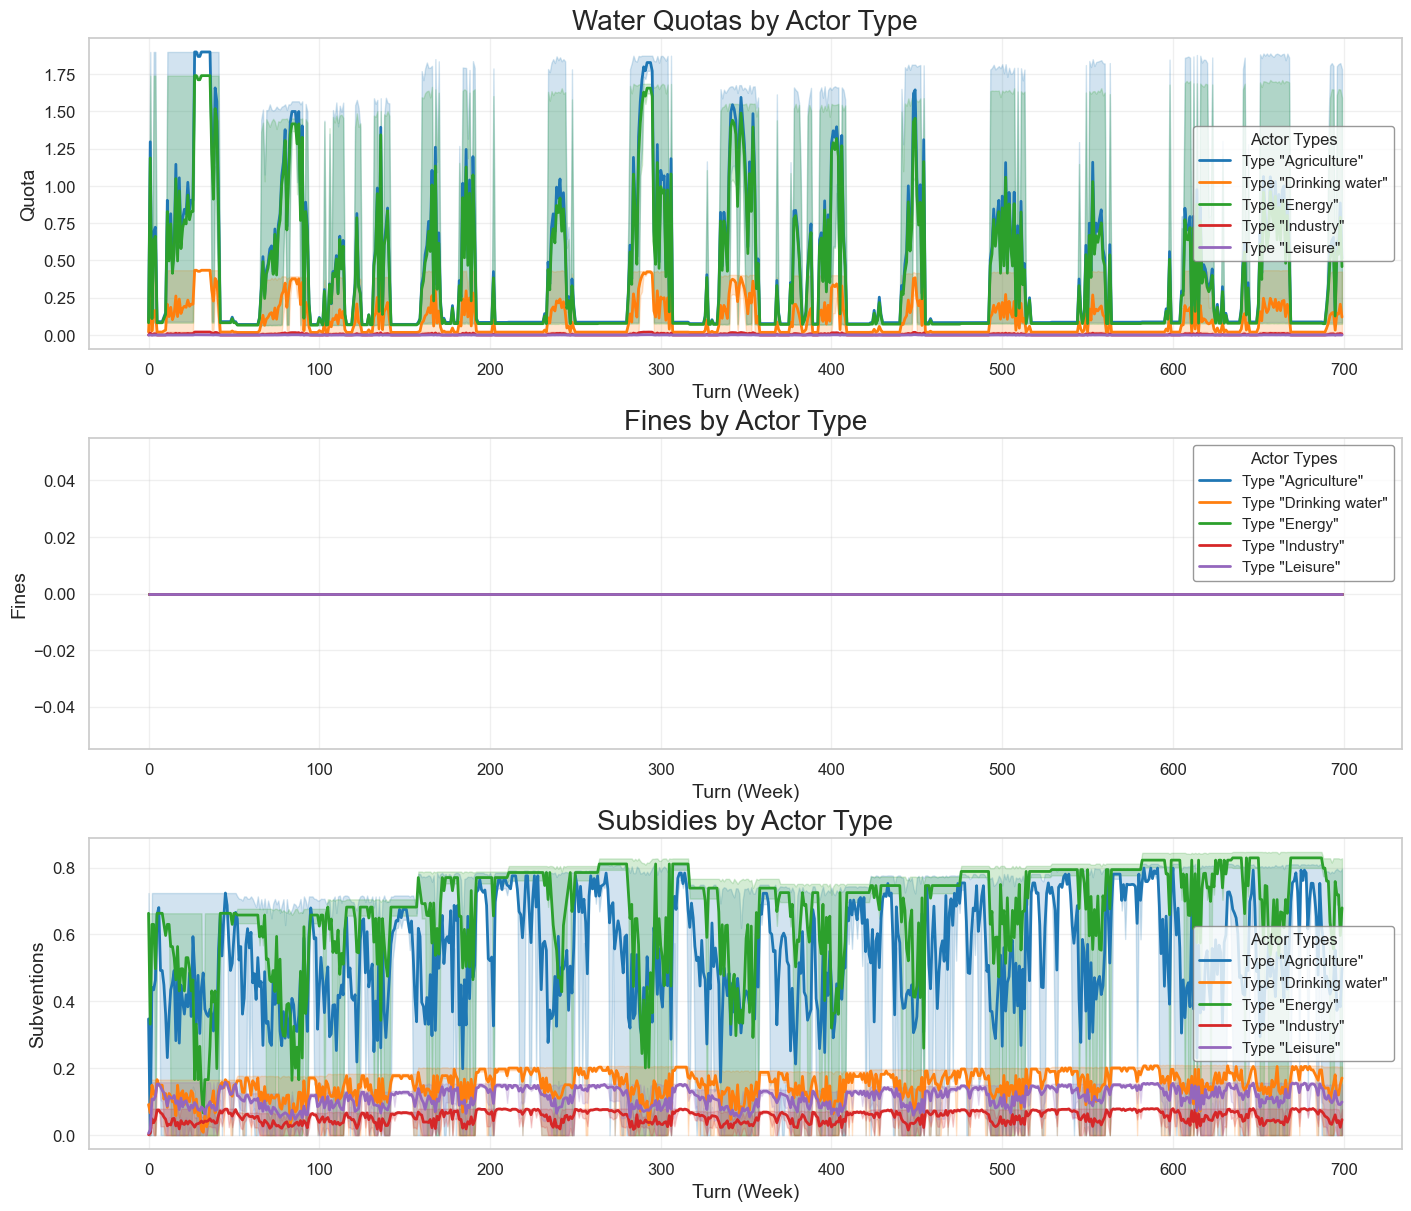

In [369]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot quotas by actor type
gtp.plot_actor_data_by_type(axes[0], x_values, simulation, "h_quota", mode="actors_mean")
axes[0].set_title('Water Quotas by Actor Type', fontsize=20)

# Plot fines and subsidies 
gtp.plot_actor_data_by_type(axes[1], x_values, simulation, "h_fines", mode="actors_mean")
axes[1].set_title('Fines by Actor Type', fontsize=20)

gtp.plot_actor_data_by_type(axes[2], x_values, simulation, "h_subventions", mode="actors_mean")
axes[2].set_title('Subsidies by Actor Type', fontsize=20)

plt.show()

### Analysis of Policy Interventions

These graphs reveal how the incentive policy worked:

- **Water Quotas**: Shows the allowed water allocation for each actor type over time.
- **Fines**: Shows penalties applied when actors exceeded their quotas.
- **Subsidies**: Shows incentives given to encourage cooperation.

The effectiveness of these tools can be evaluated by comparing them to the cooperation tendencies seen earlier.

## 5. Cumulative Impact Analysis

Finally, let's examine the cumulative impacts over the entire simulation period.

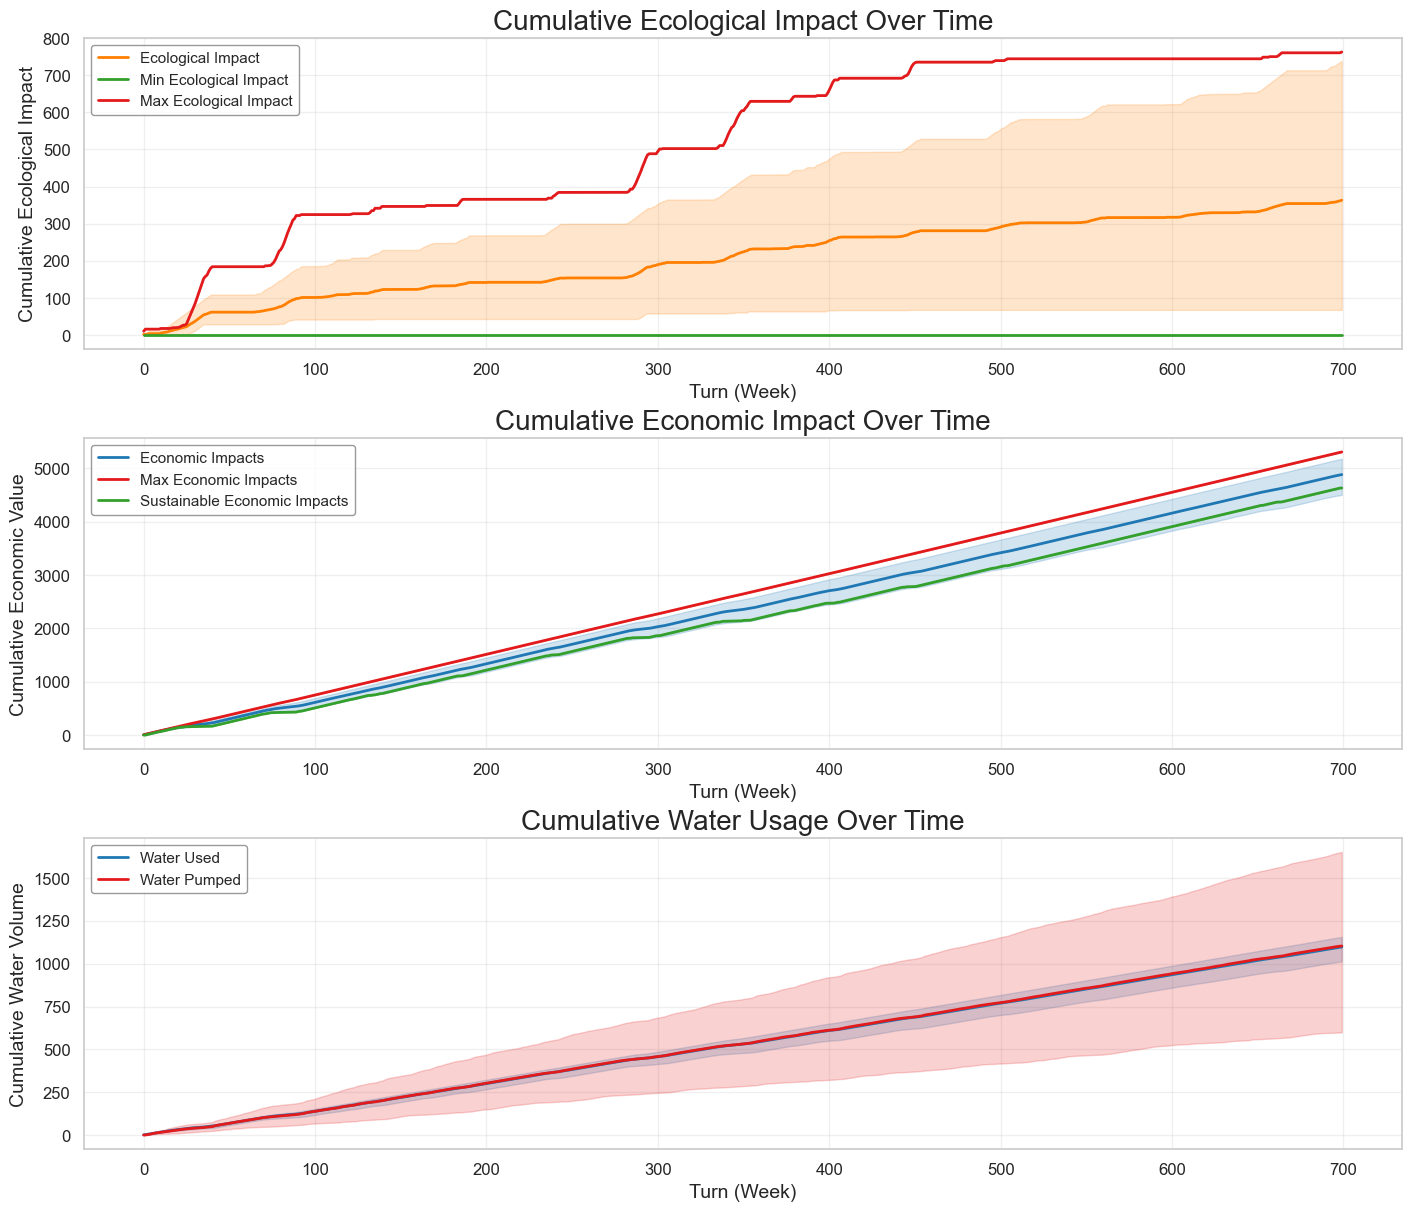

In [370]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Cumulative ecological impact
gtp.compare_data(
    axes[0], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Ecological Impact',
    title='Cumulative Ecological Impact Over Time',
    cumulative=True
)

# Cumulative economic impact
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Economic Value',
    title='Cumulative Economic Impact Over Time',
    cumulative=True
)

# Cumulative water usage
gtp.compare_data(
    axes[2], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Water Volume',
    title='Cumulative Water Usage Over Time',
    cumulative=True
)

plt.show()

### Analysis of Cumulative Impacts

These graphs show the long-term, cumulative outcomes of the policy:

- **Cumulative Ecological Impact**: Shows the total environmental impact over time.
- **Cumulative Economic Impact**: Shows the total economic value generated over time.
- **Cumulative Water Usage**: Shows the total water pumped and used over time.

These cumulative metrics are useful for evaluating the overall performance of the policy across the entire simulation period.

## 6. Actor-Specific Analysis

For a deeper understanding, let's examine how individual actors behaved.

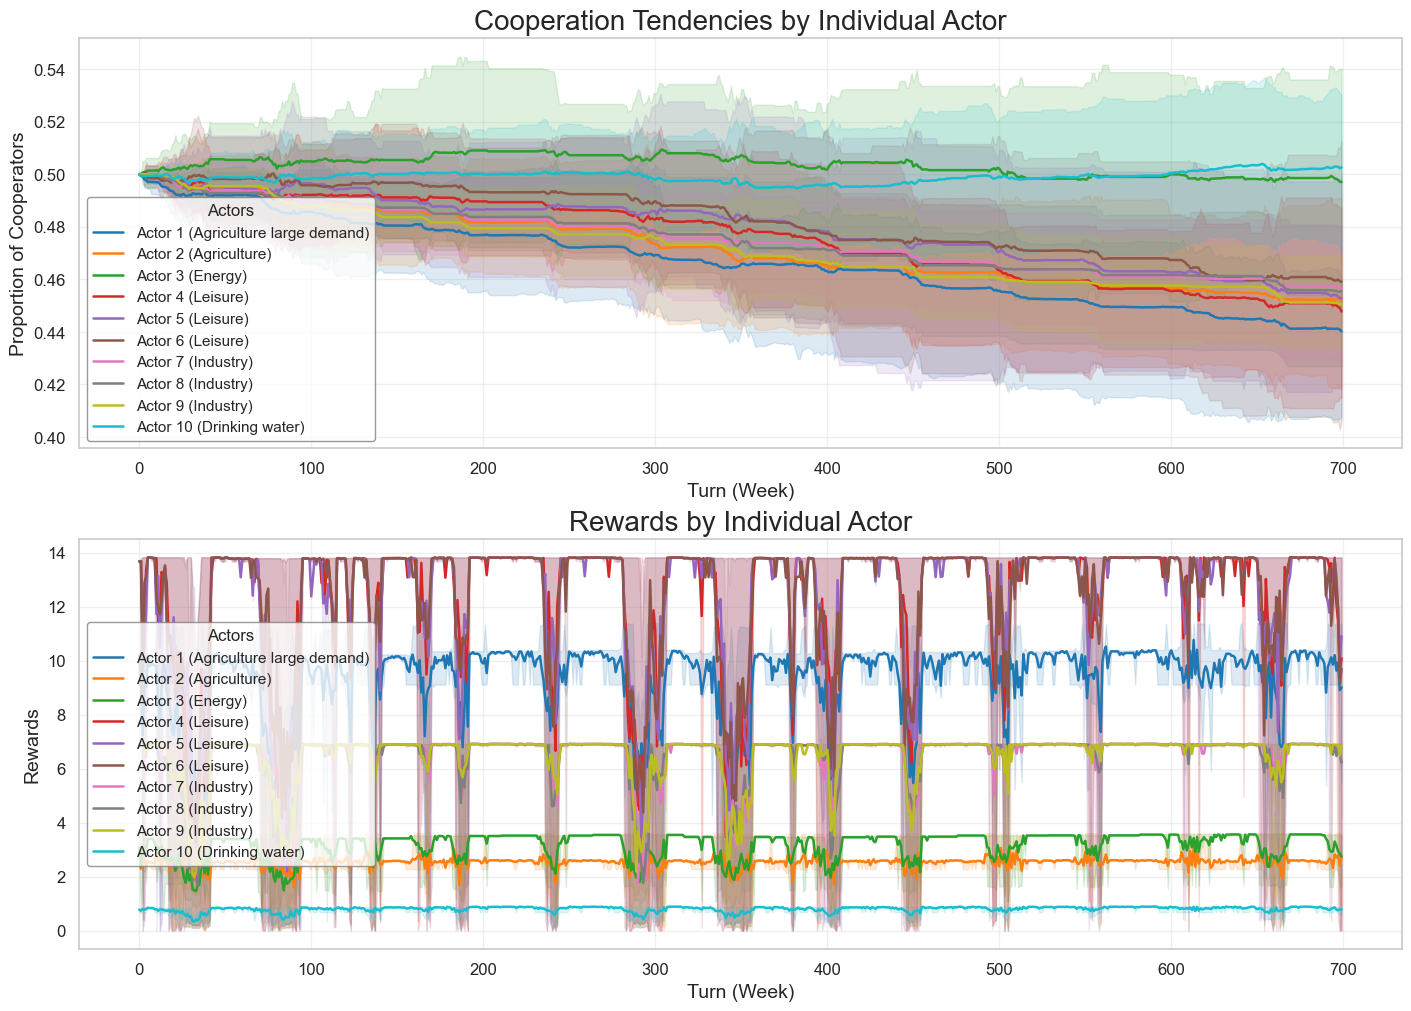

In [371]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot cooperation tendencies for individual actors
gtp.plot_actor_data(axes[0], x_values, simulation, "h_tendencies")
axes[0].set_title('Cooperation Tendencies by Individual Actor', fontsize=20)

# Plot rewards for individual actors
gtp.plot_actor_data(axes[1], x_values, simulation, "h_rewards")
axes[1].set_title('Rewards by Individual Actor', fontsize=20)

plt.show()

### Analysis of Individual Actor Behavior

These graphs provide actor-specific insights:

- **Cooperation Tendencies**: Shows how each individual actor's tendency to cooperate evolved over time.
- **Rewards**: Shows the economic rewards received by each actor.

Notice how different actors may have different strategies based on their priority, demand, and other characteristics.

## Conclusion

This analysis demonstrates how water allocation policies can influence actor behavior and overall system outcomes. The key insights are:

1. Water scarcity triggers crisis situations that require cooperation to manage effectively
2. Actors adapt their behavior based on incentives and outcomes
3. Policies must balance economic benefits against ecological integrity
4. Different actor types respond differently to incentives based on their priorities and needs

By testing different policy settings in this simulation, you can develop more effective water management strategies that promote cooperation while maintaining environmental flows.

## Next Steps

To further improve the policy, consider:

1. Adjusting quota calculations based on precise water availability
2. Fine-tuning incentive levels to better influence cooperation
3. Testing different policy combinations under various scarcity scenarios
4. Adding additional mechanisms like water trading or resource pooling